Today
==

In this project, we are going to use neural networks to predict whether a DNA sequence contains a specific pattern. Regulators (also knowm as transcription factors) bind to specific sequence patterns in our DNA, called motifs, and the neural networks will learn these motif preferences for the prediction.

We will work with simulated data to illustrate the key concepts.

We will be following a tutorial developed in the following paper:

**A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. [Read the paper here](https://www.nature.com/articles/s41588-018-0295-5).

The original version from which this course is adapted can be found linked in the above paper.

## How to Use This Tutorial

This tutorial utilizes a Colab notebook , which is an interactive computational enviroment that combines live code, visualizations, and explanatory text. To run this notebook, you may first need to make a copy by choosing **File > Save a Copy in Drive** from the menu bar (may take a few moments to save).

The notebook is organized into a series of cells. You can modify the Python command and execute each cell as you would a Jupyter notebook. To run all of the cells at once, choose **Runtime > Run all** from the menu bar.

## 0. Background

In this tutorial, we will show how to use deep learning to approach an important problem in functional genomics: **the discovery of transcription-factor binding sites in DNA**.

As we go through this notebook, we will  design a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our *independent variables* (or *predictors*), while the positive or negative response of the assay is the *dependent variable* (or *response*).

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(Spoiler alert: the true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural network doesn't know this.)

## 1. Curate the Data

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-01.png?raw=true)

In order to train the neural network, we must load and preprocess the data, which consists of DNA sequences and their corresponding labels.By processing this data, the network will learn to distinguish sequences that bind to the transcription factor from those that do not. We will split the data into three different sub-datasets:

(1) Training dataset: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

(2) Validation dataset: a second dataset used to minimize overfitting. The weights of the network are not adjusted with this data set. After each training cycle, if the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then there is overfitting on the neural network.

(3) Testing dataset: is a third dataset not included in the training nor validation data sets. After all the training and validation cycles are complete, this dataset is used only for testing the final solution in order to measure the actual predictive power of the neural network on new examples.

-----------

**INPUTS**

**Features**

We start by loading the simulated data from an external repository.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1),
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


**Q. (1 pt) Describe in your own words what distinguishes examples in the positive set from those in the negative set.**


**Q. (1 pt) How many examples are in our dataset?**



In [3]:
len(sequences)

2000

In [4]:
print(sequences)

['CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC', 'GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG', 'GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT', 'GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCTG', 'GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGGT', 'AGACATTGTCAGAACTTAGTGTGCGCCGCACTGAGCGACCGAACTCCGAC', 'CCCGGCGAAGGCTGACGAATCCTCGACCGAACTCCAGTGAAGCCAACCGG', 'AGGCAGGTGGTCGTACAATGTTTTCGAAGAGATAGGGGGCCAGAGGCCTC', 'TACTGCCTATAGCGAAGAGCGCGAGAGGTATATCGAAGAATACCGAGCAA', 'CGTATCTTCGTGTGCTCTCCTTTAGAACTGCATCTCTAGAGTCAGAGAGG', 'CCCGTTGCCTCATCTATTTTAGTTCTCGACGACCGAACTCCGTCCCGGGA', 'GCCGTCTATATCCAGAATTACTGTTGAGAAAGACGCATACCGTGCATAAT', 'TTTGAGGTTGACGATTACTTTAGTGCTTCTGACGACCGAACTCCGCGGGT', 'CCAGCAAGTCGAAGCTTACTCCATGATTTTTCACCGACCGAACTCCAGTA', 'GGTACGGCTGAGACACACATAATGGATACCAGGAACGACGTCGGCTCGAA', 'CAGACGACAATTCTCTACCACCTCGATTGAATCTAGTATCTTAAATCGGA', 'CCAAGGTGCCAGTCCTTCCTCAATGTTGGGACACACAGTACGAAGATATT', 'ACAGTACGAGCCGATCAATCCAATTCGCACGTGGGTGGGAGTGGTGTGTG', 'GCTCAAAAGAGGAATCATTCGACATT

**Labels**

Similarly, we can go ahead and load the labels (_response variables_).

In [5]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences


**Q. (1 pt) How many positive examples are there (class 1)? How many negative examples (class 0)?**



In [6]:
labels[:5]

['0', '0', '0', '1', '1']

In [7]:
pos_count=0
neg_count=0

for i in range(len(labels)):
  if labels[i]=='1':
    pos_count+=1
  if labels[i]=='0':
    neg_count+=1



In [8]:
print(f"Positive examples {pos_count}")
print(f"Negative examples {neg_count}")

Positive examples 987
Negative examples 1013


**Data formatting**

The next  step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors).

To get each DNA sequence in the form of a matrix, we use _one-hot encoding_, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In the cell below, we one-hot encode the simulated DNA sequences, and show an example of what the one-hot encoded sequence looks like:

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
# print(sequences[2])
# print(input_features[2].T)
print(input_features.T.shape)
# print(len(input_features[11]))

(4, 50, 2000)


In [11]:
# current_input=copy.deepcopy(input_features[CHOSEN_EXAMPLE,:,:])
# print(input_features[0])
print(input_features[0,:,:])
# print(input_features[:2])

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


Similarly, we can go ahead and load the labels (_response variables_). In this case, the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features. We carry out that here:

**Q. If we one-hot encode our DNA sequences, what will be the shape of our one-hot encoding? Remember, there are 4 possible bases at each position.**


In [12]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [13]:
print(len(labels))

2000


**Q. (1 pt) How are positive examples encoded? [0 1] or [1 0]?**



**Splitting data into training, validation and test sets**

We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. At a later step, we will further partition the training set into a training and validation set.

In [14]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [15]:
print(len(train_features))

1500


In [16]:
print(len(test_features))

500


**Q. (1 pt) What fraction of our dataset is in the training set? What about the test set?**

**Q. (1 pt) How would you decide what fraction of the data to use for training vs test?**


**Q. (1 pt) Why do we need both a validation set and a test set? Couldn't we test our model on the validation set?**



## 2. Select the Architecture and Train

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)

Next, we choose a neural network architecture to train the model. In this tutorial, we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of a transcription factor binding site).

We will use the deep learning library `Keras`. As of 2017, `Keras` has been integrated into `TensorFlow`,  which makes it very easy to construct neural networks. We only need to specify the kinds of layers we would like to include in our network, and the dimensionality of each layer. The CNN we generate in this example consists of the following layers:

- _Conv1D_: We define our convolutional layer to have 32 filters of size 12 bases.

- _MaxPooling1D_: After the convolution, we use a pooling layer to down-sample the output of the each of the 32 convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters.

- _Dense_: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

We can see the details of the architecture of the neural network we have created by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in our network.

In [18]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GlobalAveragePooling1D

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12,
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
# model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 39, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,226 (24.32 KB)

 Trainable params: 6,226 (24.32 KB)

 Non-trainable params: 0 (0.00 B)

**Q. (1 pt) Why do we use a sigmoid activation function for the last layer, and rectified linear units in the other layers?**

**Q. (1 pt). Loss function: What does binary cross entropy measure?**

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

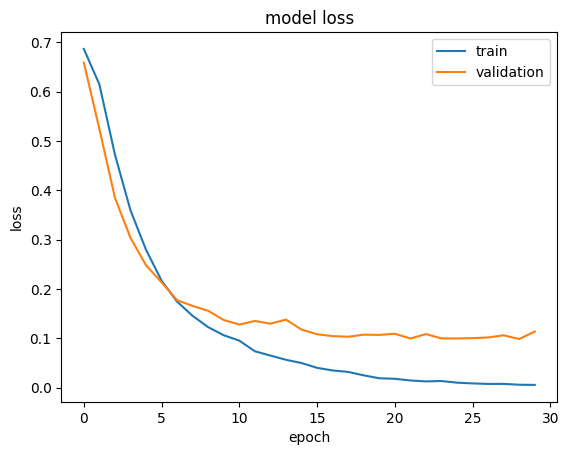

In [19]:
history = model.fit(train_features, train_labels,
                    epochs=30, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Other metrics may be used in different tasks -- for example, the _mean squared error_ is typically used to measure the accuracy for continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight and systolic blood pressure).

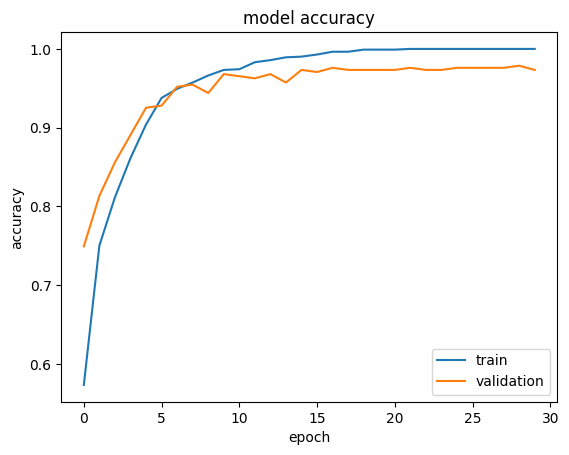

In [20]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

**Q. (1 pt). Why do you think the accuracy on the validation set is lower than that on the training set?**



## 3. Evaluate

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix. Nearly every test sequence should be correctly classified.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Confusion matrix:
 [[246  13]
 [  4 237]]


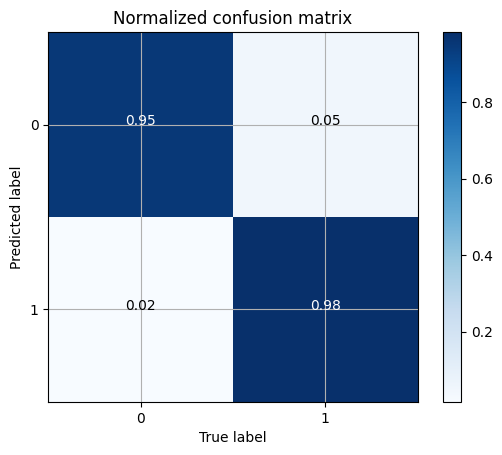

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1),
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

**Q. (1 pt). What is the fraction of true positives (TP)? What about false positives (FP)? What about false negatives (FN)**

In [22]:
precision=cm[1,1]/(cm[1,1]+cm[1,0])
recall=cm[1,1]/(cm[1,1]+cm[0,1])
print(precision,recall)

0.983402489626556 0.9514384028768057


In [23]:
TP = cm[1, 1]
FP = cm[1, 0]
FN = cm[0, 1]
TN = cm[0, 0]

In [24]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"accuracy: {accuracy}")

accuracy: 0.966604719716753


**Q. (1 pt) What are the precision and recall of the model?**

**Q. (1 pt) Does this model perform well?**

## 4. Interpret

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-31.png?raw=true)

**Interpretation using in silico mutagenesis**

We are now going to identify which bases in the our input sequences are important for the predictions that the model makes. We will use a method called in silico mutagenesis, or ISM.

ISM takes each position in our sequence, and changes the true base that position for each other possible option, and checks how the prediction of the model changes. If changing a base changes the prediction significantly, it means the base was important for the prediction. This is what to expect to happen for bases that are part of the pattern we included in the sequences from our positive set.

Let's try ISM for one example (example 1999).

In [25]:
for sequence in sequences[:2]:
  print(sequence)

CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC
GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG


In [26]:
def plot_ism(ism_out, CHOSEN_EXAMPLE):
  x=0.0000005
  ism_out2=pd.DataFrame(ism_out[0,:,:].T,columns=[*sequences[CHOSEN_EXAMPLE]],index=['A','C','G','T'])
  sns.clustermap(-ism_out2,vmin=-x,vmax=x,cmap='bwr',figsize=(10,2),
                row_cluster=False,col_cluster=False,xticklabels=True,
                ).fig.suptitle(f'DNA Sequence {CHOSEN_EXAMPLE}')


In [27]:
import copy
import seaborn as sns

def fill_in_ism(CHOSEN_EXAMPLE):
  ism_out=np.zeros((1,50,4))

  for i in range(50):
    for b in range(4):
      current_input=copy.deepcopy(input_features[CHOSEN_EXAMPLE,:,:])
      current_input=np.expand_dims(current_input, axis=0)
      old_label=model.predict(current_input, verbose=0)
      current_input[0,i,:]=0
      current_input[0,i,b]=1
      new_label=model.predict(current_input, verbose=0)
      ism_out[0,i,b]=old_label[0,1]-new_label[0,1]

  plot_ism(ism_out, CHOSEN_EXAMPLE)


In [28]:
from tqdm import tqdm

100%|██████████| 20/20 [08:48<00:00, 26.45s/it]


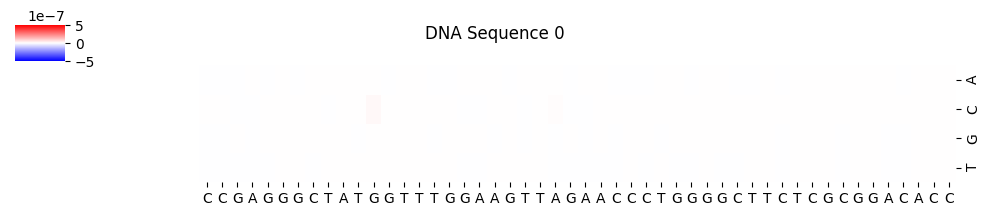

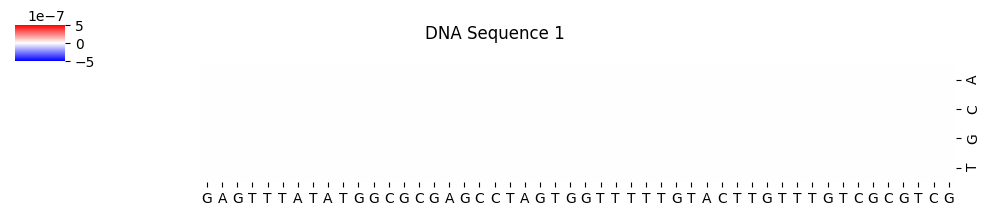

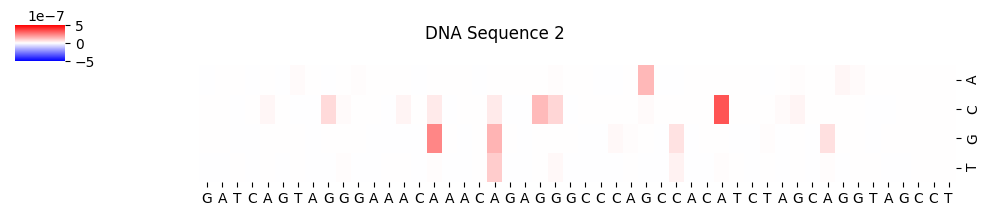

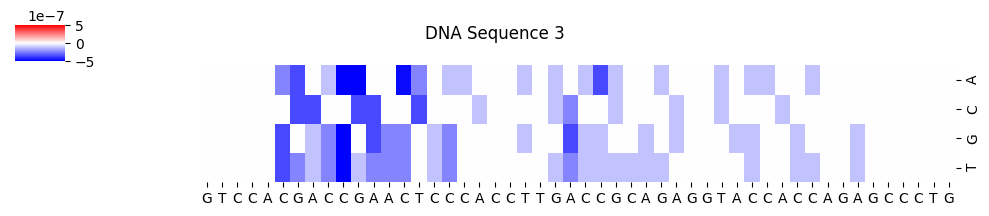

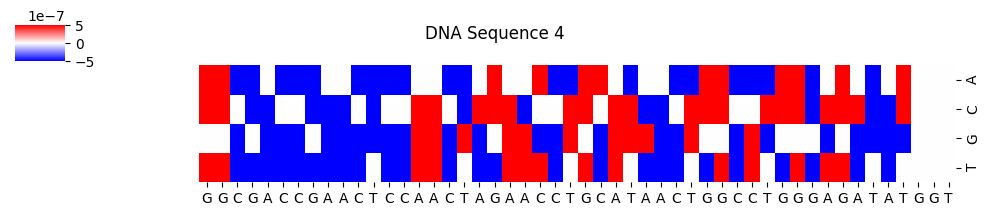

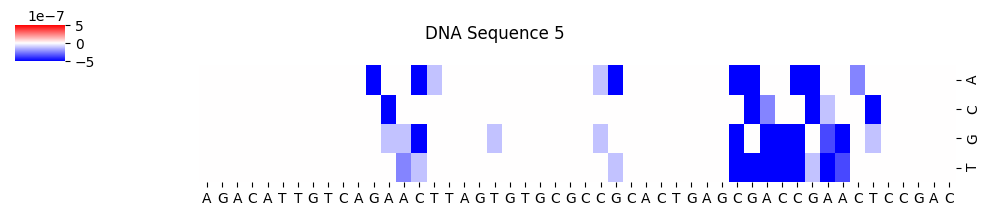

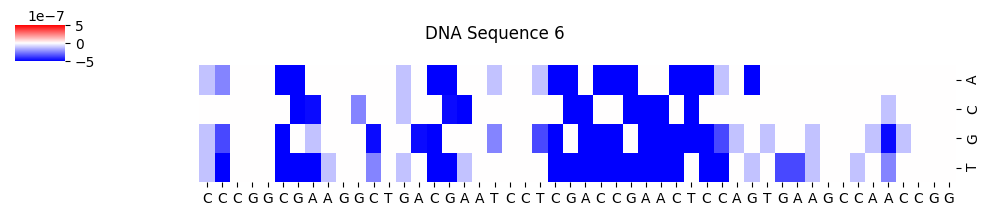

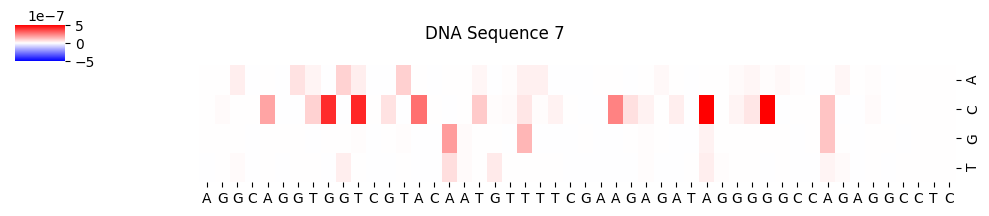

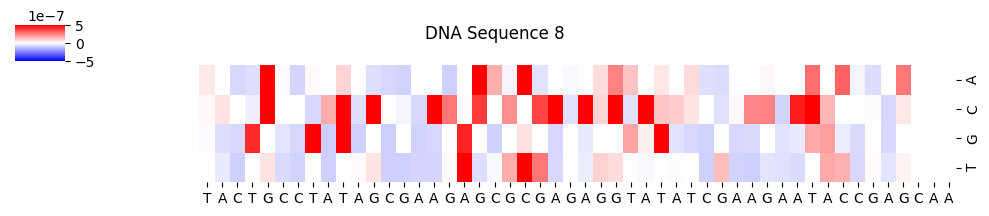

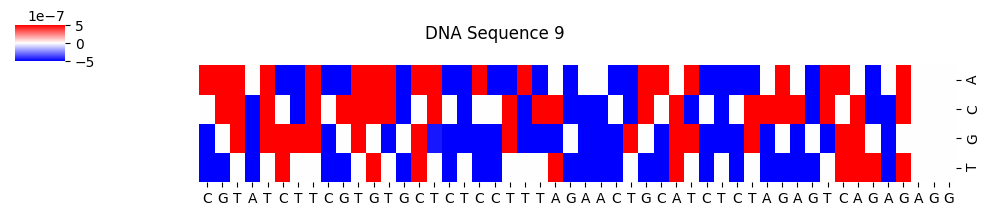

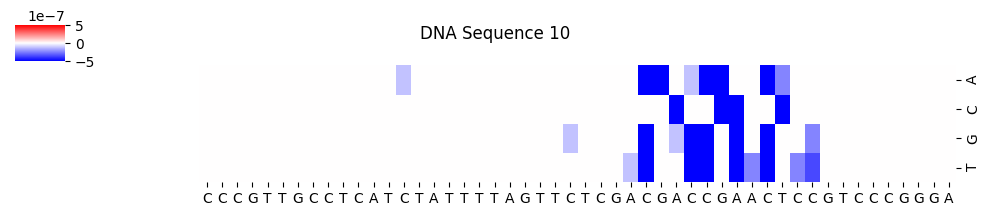

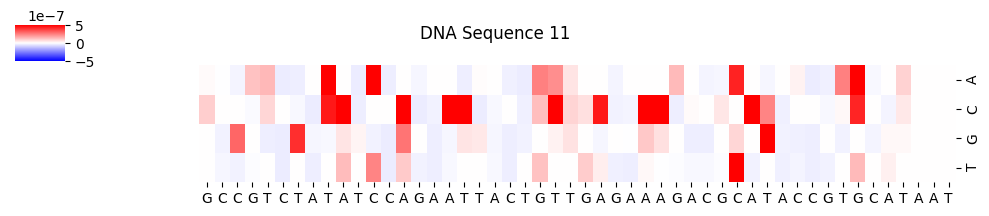

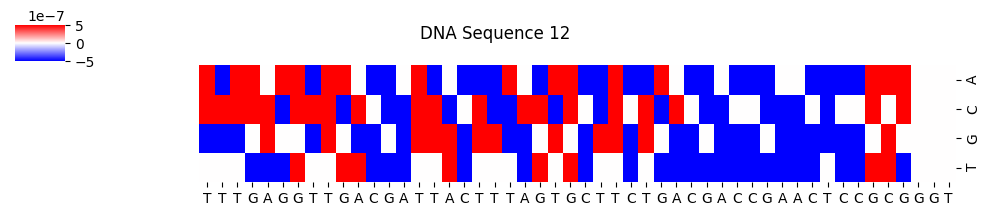

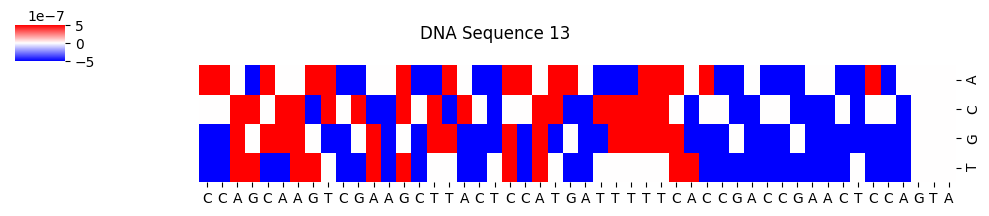

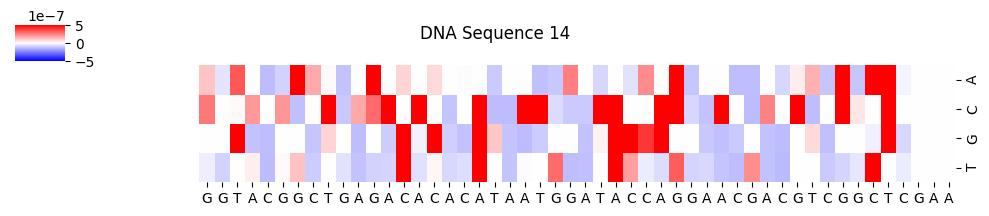

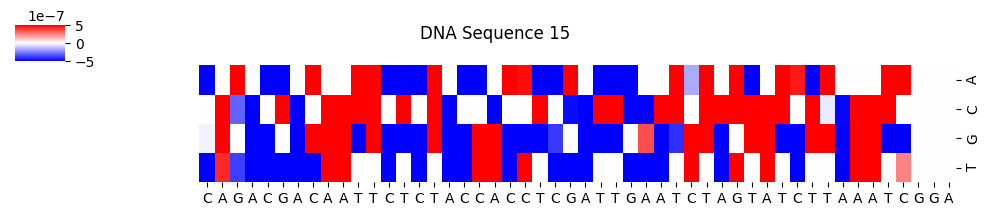

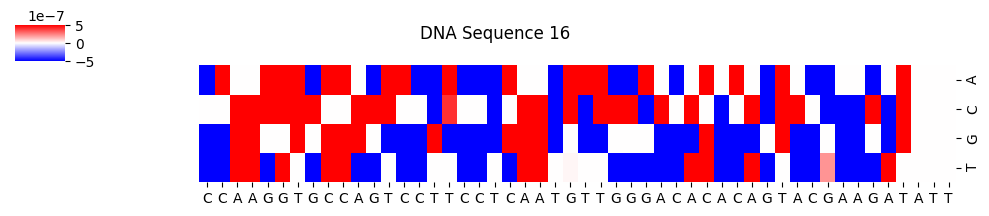

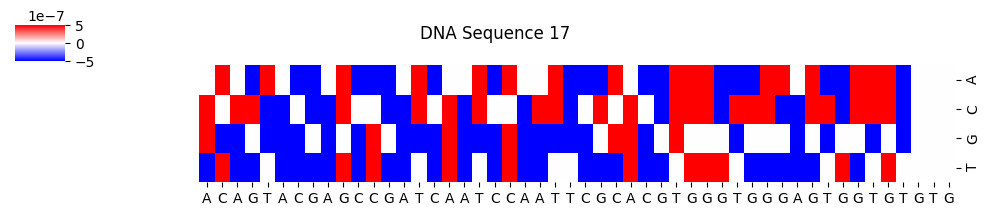

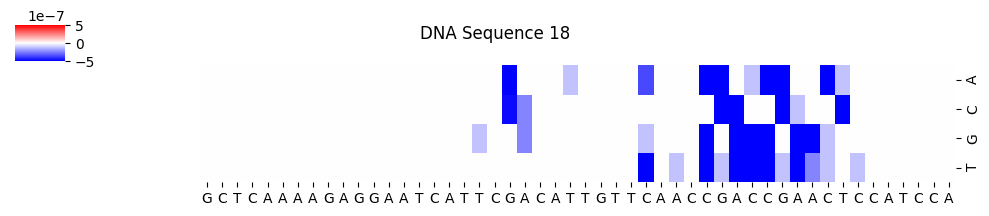

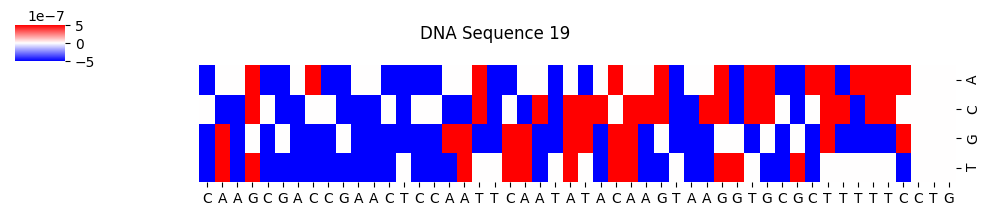

In [61]:
for i in tqdm(range(20)):
  fill_in_ism(i)
  plt.savefig(f"DNA Sequence {i}", dpi=300)

In [65]:
!pwd

/content


In [70]:
from google.colab import files
for i in range(20):
  files.download(f'DNA Sequence {i}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import copy
CHOSEN_EXAMPLE=1999
ism_out=np.zeros((1,50,4))

for i in range(50):
  #print(i)
  for b in range(4):
    current_input=copy.deepcopy(input_features[CHOSEN_EXAMPLE,:,:])
    current_input=np.expand_dims(current_input, axis=0)
    old_label=model.predict(current_input, verbose=0)
    current_input[0,i,:]=0
    current_input[0,i,b]=1
    new_label=model.predict(current_input, verbose=0)
    ism_out[0,i,b]=old_label[0,1]-new_label[0,1]

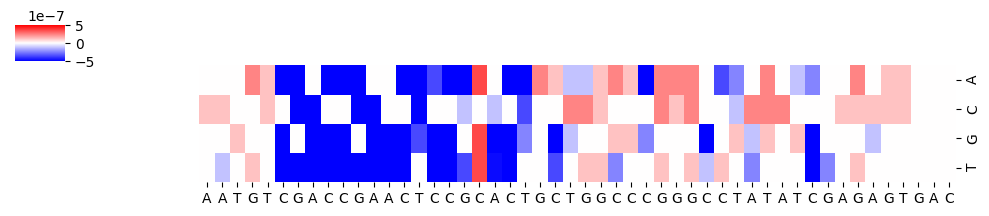

In [26]:
x=0.0000005
ism_out2=pd.DataFrame(ism_out[0,:,:].T,columns=[*sequences[CHOSEN_EXAMPLE]],index=['A','C','G','T'])
sns.clustermap(-ism_out2,vmin=-x,vmax=x,cmap='bwr',figsize=(10,2),
               row_cluster=False,col_cluster=False,xticklabels=True,
               )

The results above should show high differences in prediction for the bases _CGACCGAACTCC_ appearing in the DNA sequence. If you recall from the top of the document, this is exactly the motif that we embedded in the positive sequences! The changes in prediction values may be non-zero for other bases as well -- the  method is not perfect, and there other more complex interpretation methods that are used in practice to obtain better results.  

Furthermore, we may explore other architectures for our neural network to see if we can improve performance on the validation dataset. For example, we could choose different _hyper-parameters_, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the binding motif.

In [55]:
kernels, biases = model.layers[0].get_weights()
print(kernels.shape)
print(biases.shape)

(12, 4, 32)
(32,)


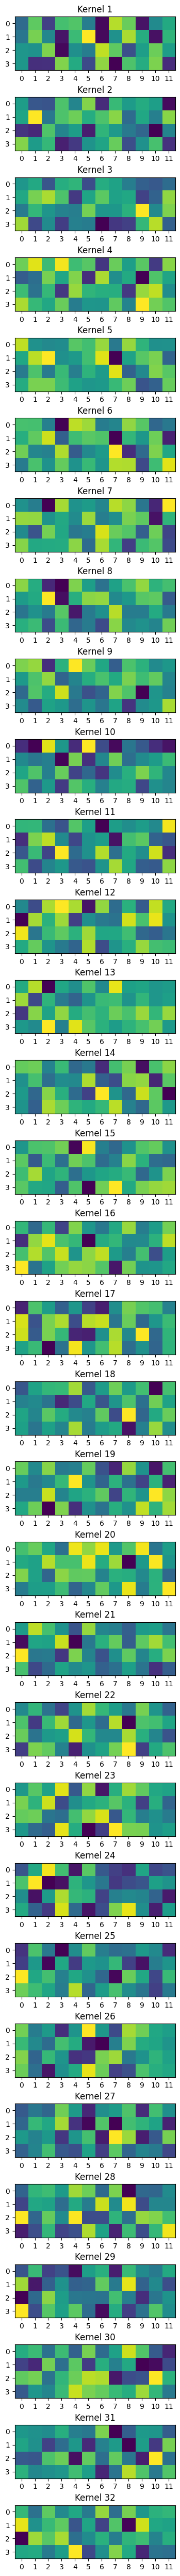

In [90]:
number_kernels = 32

plt.figure(figsize=(10, 2 * number_kernels))

for i in range(number_kernels):
  plt.subplot(number_kernels, 1, i+1)
  plt.imshow(kernels[:, :, i].T)
  plt.xticks([i for i in range(kernels.shape[0])])
  plt.yticks([i for i in range(kernels.shape[1])])
  plt.title(f"Kernel {i+1}")
  plt.subplots_adjust(hspace=0.5)